In [1]:
import os
import pandas as pd
import numpy as np
import pickle

from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import *

from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


---

### First, copy-paste the setup from the notebook that produced the pretrained classweights.
This time we load also the test-data into memory
(Note to self: learn how to make imports from other notebooks...)

In [2]:
global_params = pickle.load(open("global_params.p", "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [3]:
# n_sample=100_000

In [25]:
X_train = np.load(os.path.join("data", "Kdata", "X_train.npy"))
y_train = np.load(os.path.join("data", "Kdata", "y_train.npy"))
X_val = np.load(os.path.join("data", "Kdata", "X_val.npy"))
y_val = np.load(os.path.join("data", "Kdata", "y_val.npy"))
X_test = np.load(os.path.join("data", "Kdata", "X_test.npy"))
y_test = np.load(os.path.join("data", "Kdata", "y_test.npy"))

### Start of boilerplate

In [26]:
from keras import backend as K

# Custom metrics.
# Note that any metric is computed per batch during training
# (hence one needs large batches for it to make sense).
# Also, there is the implicit 0.5 treshold in the K.round function below

def macroPrec(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec


def macroRecall(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    return macroF1



# Custom loss functions
# No clippping or rounding as those are not differentiable
# Note to self: these functions are already taking into account class imbalances, so remeber
# not to set the class_weight argument in fitting method when using them as the loss 

# semi macroF1
def fuzzy_macroF1_flip(y_true, y_pred):

    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) ) 
    
    return 1-macroF1


# # weighted categorical crossentropy
# def my_crossE(y_true, y_pred):
    
#     class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
#     weighted_entropy = K.mean(class_weights * class_entropy)
#     return -4E-4 * weighted_entropy  # arbitrary coefficient to make it close to [0-1] interval


# take average of the last two, because why not
def my_loss(y_true, y_pred):
    # return 0.5*(fuzzy_macroF1_flip(y_true, y_pred) + my_crossE(y_true, y_pred))
    
    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1p2 = K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = K.mean(class_weights * class_entropy)
    
    return 0.5 - macroF1p2 - 2E-4 * weighted_entropy

In [27]:
# auxiliary functions
    

# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history):
    
    plt.figure(figsize=(18, 5))
    
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, 3, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, 3, 2)
    markers = ['b', 'r',  'g', 'y', 'm', 'c', 'k']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history[metric]
        val_results = history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    lr = history['lr'] # learning rate
    plt.plot(x, lr, 'k', label='Learning rate')
    plt.title('Learning rate')  
    plt.legend()
    

# choose callbacks to be given in model.fit(...)
class WakeEmbedding(Callback):
    
    def __init__(self, rel_lr_treshold):
        self.rel_lr_treshold = rel_lr_treshold
    
    def on_train_begin(self, logs={}):
        self.init_lr =  K.eval(self.model.optimizer.lr)
        
    def on_epoch_begin(self, epoch, logs={}):
        lr =  K.eval(self.model.optimizer.lr)
        if (lr / self.init_lr) <= self.rel_lr_treshold:
            self.model.layers[0].trainable = True
        print("Embedding trainable:", self.model.layers[0].trainable)


def callbacks(plateau_factor=0.5, plateau_patience=1,\
              early_s_patience = 2,\
              waking0th=True, wake_treshold = 0.5
             ):
    
    callbacks = [ReduceLROnPlateau(factor=plateau_factor,\
                                   monitor='val_macroF1', mode='max', patience = plateau_patience),
                EarlyStopping(monitor='val_macroF1', mode='max', patience=early_s_patience)
               ]
    
    return callbacks + [WakeEmbedding(wake_treshold)] if waking0th else callbacks


# callbacks = [ReduceLROnPlateau(factor=0.5,\
#                                monitor='val_macroF1', mode='max', patience = 1),
#              EarlyStopping(monitor='val_macroF1', mode='max', patience=2),
#             WakeEmbedding(0.5)
#            ]


# some other global learning settings

batch_size = 3000
# defualt lr = 0.001
optimizer = 'adam'
# optimizer = optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999,\
#                             epsilon=None, decay=0.0, amsgrad=False)
my_metrics = [macroPrec, macroF1, macroRecall] #, my_crossE, fuzzy_macroF1_flip, my_loss]

Take not of the ***WakeEmbedding()*** callback, which is meant to unfreeze the embedding layer when the *ReduceOnPlateau* drops the learning rate by a certain factor (possibly already directly after the firts intervention of *ReduceOP*).

---

In [28]:
# the workhorse

class BlackBox():
    
    def __init__(self, layers, loss, metrics, callbacks=callbacks(), class_weight=class_weights, epochs=3,\
                 embedd = None, embedd_dims=[None]*3, train_weights=False, mask_zeros=True):
        
        self.layers = layers
        self.loss = loss
        self.metrics = metrics
        self.callbacks = callbacks
        self.class_weight = class_weight
        self.epochs = epochs
        self.train_weigts = train_weights
        self.mask_zeros = mask_zeros
        self.history = None
        self.test_results = None
        
        self.model = Sequential()
        if embedd:
            self.input_dim = embedd_dims[0] # num_words
            self.output_dim = embedd_dims[1] # dimension of the embedding space
            self.input_length = embedd_dims[2] # padded_length
            with open(embedd, "rb") as f:
                self.embedd_weights = pickle.load(f)
            
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=self.train_weigts,\
                                     mask_zero=self.mask_zeros
                                    )
                          )
            self.model.layers[0].trainable = self.train_weigts  # szczeżonego panbug szczeże
            
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
    
    def summary(self):
        return self.model.summary()
    
    def fit(self, epochs=50):
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=self.class_weight,
            epochs=self.epochs,
            batch_size=batch_size,
            #validation_split=0.1,
            validation_data=(X_val, y_val),
            callbacks=self.callbacks,
            verbose = 1        
            )
        
    def reset(self):
        
        self.history = None
        self.test_results = None
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        
    def evaluate(self, X_test, y_test):
        print(f'Loss function: {self.loss.__name__ if callable(self.loss) else self.loss}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        self.test_results = self.model.evaluate(X_test, y_test)
        return self.test_results
    
    def plot(self):
        plot_history(self.history.history)
        
    def save_embedd(self, name):
        file = os.path.join("my_embeddings", f"weights_{name}.p")
        with open(file, 'wb') as f:
            pickle.dump(self.model.layers[0].get_weights(), f)
        
    def Ksave(self, name):
        file = os.path.join("my_embeddings", f"Kmodel_from_{name}.h5")
        self.model.save(file)
    
    def save_hist(self, name):
        file = os.path.join("my_embeddings", f"history_of_{name}.p")
        with open(file, 'w') as f:
            json.dump(self.history.history, f) 


In [29]:
custom_objects={'macroPrec': macroPrec,\
                'macroF1': macroF1,\
                'macroRecall': macroRecall,\
#                 'my_crossE': my_crossE,\
                 'fuzzy_macroF1_flip': fuzzy_macroF1_flip,\
                'my_loss': my_loss
               }

### End of boilerplate

---
---

In [10]:
embedd_file_1 = os.path.join("my_embeddings", "weights_50dim_GlblAvg_CatCrossE_10epochs.p")
embedd_file_2 = os.path.join("my_embeddings", "weights_50dim_GlblAvg_F1flip_10epochs.p")
embedd_file_3 = os.path.join("my_embeddings", "weights_50dim_GlblAvg_MyLoss_10epochs.p")

---

### Dense nets

In [12]:
# embedding: keras layer, trained
# structure: dense layers

layers1a = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=False),\
            Dropout(0.3),
            Dense(24, activation='relu'),
           Dropout(0.1),
           Dense(8, activation='relu'),
            Dropout(0.1),
            Dense(24, activation='relu'),
           Dropout(0.1),
            Flatten()
          ]

model1a = BlackBox(layers=layers1a, loss=my_loss, metrics=my_metrics, class_weight=None,\
                   epochs=20,\
                   callbacks = callbacks(waking0th=False)
                  )
model1a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dense_7 (Dense)              (None, 679, 24)           1224      
_________________________________________________________________
dropout_7 (Dropout)          (None, 679, 24)           0         
_________________________________________________________________
dense_8 (Dense)              (None, 679, 8)            200       
_________________________________________________________________
dropout_8 (Dropout)          (None, 679, 8)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 679, 24)           216       
_________________________________________________________________
dropout_9 (Dropout)          (None, 679, 24)           0         
__________

In [13]:
model1a.fit() # my_loss

Train on 100000 samples, validate on 100000 samples
Epoch 1/20
100000/100000 [==============================] - 207s 2ms/step - loss: 0.6024 - macroPrec: 0.1016 - macroF1: 0.0274 - macroRecall: 0.0190 - val_loss: 0.5686 - val_macroPrec: 0.2422 - val_macroF1: 0.1381 - val_macroRecall: 0.1180
Epoch 2/20
100000/100000 [==============================] - 198s 2ms/step - loss: 0.5033 - macroPrec: 0.3367 - macroF1: 0.2474 - macroRecall: 0.2180 - val_loss: 0.4446 - val_macroPrec: 0.4333 - val_macroF1: 0.3548 - val_macroRecall: 0.3298
Epoch 3/20
100000/100000 [==============================] - 198s 2ms/step - loss: 0.4050 - macroPrec: 0.4898 - macroF1: 0.4188 - macroRecall: 0.3949 - val_loss: 0.3879 - val_macroPrec: 0.5013 - val_macroF1: 0.4664 - val_macroRecall: 0.4414
Epoch 4/20
100000/100000 [==============================] - 198s 2ms/step - loss: 0.3445 - macroPrec: 0.5911 - macroF1: 0.5269 - macroRecall: 0.5219 - val_loss: 0.3614 - val_macroPrec: 0.5690 - val_macroF1: 0.5149 - val_macroRec

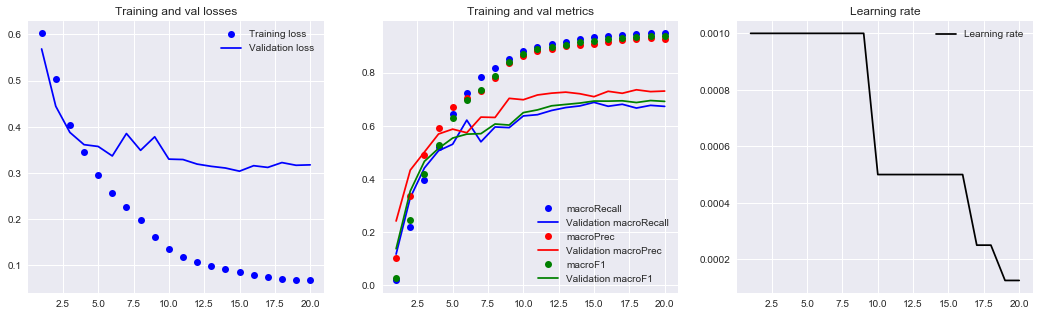

In [19]:
model1a.plot()

---

### Convolutions

In [22]:
# embedding: keras layer, trained
# structure: convolution layers

layers2a = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=False),\
            Dropout(0.5),
            Conv1D(10, 4),
            Conv1D(10, 4),
            Conv1D(10, 4),
            Flatten()
           ]

model2a = BlackBox(layers=layers2a, loss=my_loss, metrics=my_metrics, class_weight=None,\
                   epochs=20,\
                   callbacks = callbacks(waking0th=False)
                  )
model2a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dropout_5 (Dropout)          (None, 679, 50)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 676, 10)           2010      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 673, 10)           410       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 670, 10)           410       
_________________________________________________________________
flatten_5 (Flatten)          (None, 6700)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 40206     
Total para

In [23]:
model2a.fit() # my_loss

Train on 100000 samples, validate on 100000 samples
Epoch 1/20
100000/100000 [==============================] - 224s 2ms/step - loss: 0.5798 - macroPrec: 0.1610 - macroF1: 0.0790 - macroRecall: 0.0647 - val_loss: 0.4829 - val_macroPrec: 0.4216 - val_macroF1: 0.3469 - val_macroRecall: 0.2996
Epoch 2/20
100000/100000 [==============================] - 219s 2ms/step - loss: 0.3930 - macroPrec: 0.4954 - macroF1: 0.4590 - macroRecall: 0.4523 - val_loss: 0.3417 - val_macroPrec: 0.5549 - val_macroF1: 0.5458 - val_macroRecall: 0.5681
Epoch 3/20
100000/100000 [==============================] - 218s 2ms/step - loss: 0.2935 - macroPrec: 0.6206 - macroF1: 0.6276 - macroRecall: 0.6808 - val_loss: 0.3158 - val_macroPrec: 0.5976 - val_macroF1: 0.6062 - val_macroRecall: 0.6308
Epoch 4/20
100000/100000 [==============================] - 219s 2ms/step - loss: 0.2362 - macroPrec: 0.6767 - macroF1: 0.7065 - macroRecall: 0.7947 - val_loss: 0.3213 - val_macroPrec: 0.6082 - val_macroF1: 0.6182 - val_macroRec

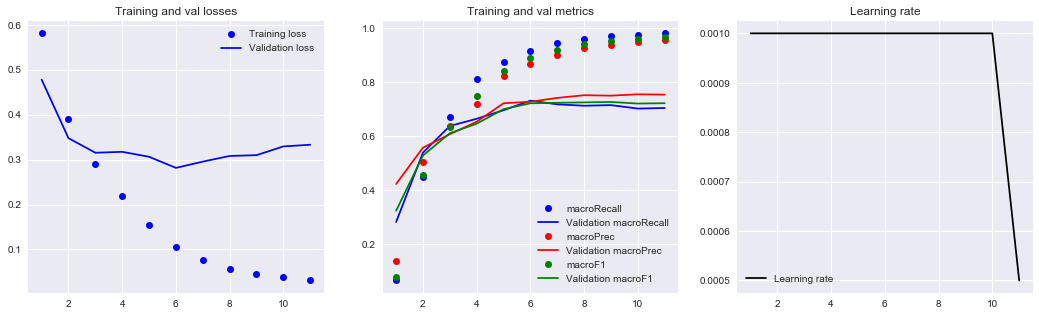

In [31]:
model2a.plot() # 2 x Conv(20,4)

In [16]:
# embedding: keras layer, trained
# structure: convolution layers

layers2b = [Dropout(0.5),
            Conv1D(10, 4),
            Conv1D(10, 4),
            Conv1D(10, 4),
            Flatten()
           ]

model2b = BlackBox(layers=layers2b, loss=my_loss, metrics=my_metrics, class_weight=None,\
                   epochs=20,\
                   embedd = embedd_file_3,\
                   embedd_dims=[num_words, 50, padded_length],\
                   train_weights=True,
                   mask_zeros=False,
                   callbacks = callbacks(waking0th=False)
                  )
model2b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dropout_3 (Dropout)          (None, 679, 50)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 676, 10)           2010      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 673, 10)           410       
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 670, 10)           410       
_________________________________________________________________
flatten_3 (Flatten)          (None, 6700)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 40206     
Total para

In [17]:
model2b.fit()

Train on 100000 samples, validate on 100000 samples
Epoch 1/20
100000/100000 [==============================] - 220s 2ms/step - loss: 0.3460 - macroPrec: 0.6592 - macroF1: 0.5404 - macroRecall: 0.5204 - val_loss: 0.2271 - val_macroPrec: 0.7260 - val_macroF1: 0.7496 - val_macroRecall: 0.7919
Epoch 2/20
100000/100000 [==============================] - 218s 2ms/step - loss: 0.1831 - macroPrec: 0.7594 - macroF1: 0.7894 - macroRecall: 0.8356 - val_loss: 0.2123 - val_macroPrec: 0.7257 - val_macroF1: 0.7574 - val_macroRecall: 0.8128
Epoch 3/20
100000/100000 [==============================] - 218s 2ms/step - loss: 0.1573 - macroPrec: 0.7860 - macroF1: 0.8162 - macroRecall: 0.8605 - val_loss: 0.1966 - val_macroPrec: 0.7525 - val_macroF1: 0.7747 - val_macroRecall: 0.8129
Epoch 4/20
100000/100000 [==============================] - 219s 2ms/step - loss: 0.1377 - macroPrec: 0.7994 - macroF1: 0.8337 - macroRecall: 0.8831 - val_loss: 0.1971 - val_macroPrec: 0.7681 - val_macroF1: 0.7846 - val_macroRec

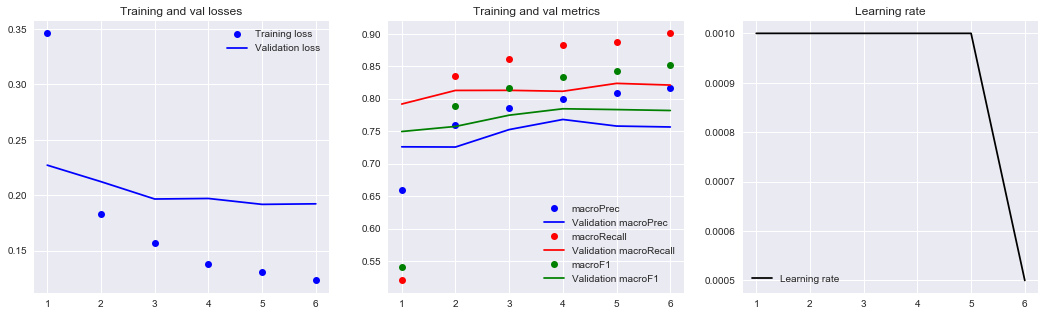

In [18]:
model2b.plot()

In [19]:
# embedding: keras layer, trained
# structure: convolution layers

layers2c = [Dropout(0.5),
            Conv1D(10, 4),
            Conv1D(10, 4),
            Conv1D(10, 4),
            Flatten()
           ]

model2c = BlackBox(layers=layers2c, loss=my_loss, metrics=my_metrics, class_weight=None,\
                   epochs=20,\
                   embedd = embedd_file_3,\
                   embedd_dims=[num_words, 50, padded_length],\
                   train_weights=False,
                   mask_zeros=False,
                   callbacks = callbacks(waking0th=True)
                  )
model2c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dropout_4 (Dropout)          (None, 679, 50)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 676, 10)           2010      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 673, 10)           410       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 670, 10)           410       
_________________________________________________________________
flatten_4 (Flatten)          (None, 6700)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 40206     
Total para

In [20]:
model2c.fit()

Train on 100000 samples, validate on 100000 samples
Epoch 1/20
Embedding trainable: False
100000/100000 [==============================] - 198s 2ms/step - loss: 0.3640 - macroPrec: 0.6122 - macroF1: 0.5172 - macroRecall: 0.5144 - val_loss: 0.2410 - val_macroPrec: 0.7031 - val_macroF1: 0.7324 - val_macroRecall: 0.7852
Epoch 2/20
Embedding trainable: False
100000/100000 [==============================] - 197s 2ms/step - loss: 0.1790 - macroPrec: 0.7549 - macroF1: 0.7909 - macroRecall: 0.8456 - val_loss: 0.2002 - val_macroPrec: 0.7413 - val_macroF1: 0.7726 - val_macroRecall: 0.8214
Epoch 3/20
Embedding trainable: False
100000/100000 [==============================] - 198s 2ms/step - loss: 0.1556 - macroPrec: 0.7799 - macroF1: 0.8147 - macroRecall: 0.8660 - val_loss: 0.1978 - val_macroPrec: 0.7432 - val_macroF1: 0.7751 - val_macroRecall: 0.8234
Epoch 4/20
Embedding trainable: False
100000/100000 [==============================] - 197s 2ms/step - loss: 0.1483 - macroPrec: 0.7878 - macroF1: 

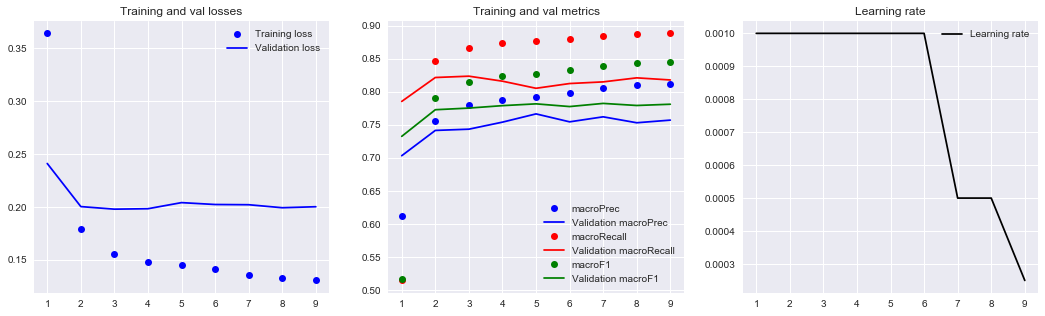

In [21]:
model2c.plot()

---

### Recurrent NNEts

In [19]:
# embedding: keras layer, trained
# structure: birectional fully connected RNN layer + dense

layers3a = [Bidirectional(SimpleRNN(80, dropout=0.0, recurrent_dropout=0.0)),
           ]

model3a = BlackBox(layers=layers3a, loss=my_loss, metrics=my_metrics,\
                   epochs=100,\
                   embedd = embedd_file_1,\
                   embedd_dims=[num_words, 50, padded_length])
model3a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 160)               20960     
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 966       
Total params: 13,887,126
Trainable params: 21,926
Non-trainable params: 13,865,200
_________________________________________________________________


In [20]:
model3a.fit()

Train on 500000 samples, validate on 200000 samples
Epoch 1/100
Embedding trainable: False
500000/500000 [==============================] - 1094s 2ms/step - loss: 0.3110 - macroPrec: 0.6446 - macroF1: 0.6298 - macroRecall: 0.6747 - val_loss: 0.2705 - val_macroPrec: 0.6558 - val_macroF1: 0.6912 - val_macroRecall: 0.7463
Epoch 2/100
Embedding trainable: False
500000/500000 [==============================] - 1084s 2ms/step - loss: 0.2940 - macroPrec: 0.6205 - macroF1: 0.6418 - macroRecall: 0.7302 - val_loss: 0.3154 - val_macroPrec: 0.6019 - val_macroF1: 0.6292 - val_macroRecall: 0.6996
Epoch 3/100
Embedding trainable: True
500000/500000 [==============================] - 1062s 2ms/step - loss: 0.2838 - macroPrec: 0.6212 - macroF1: 0.6570 - macroRecall: 0.7541 - val_loss: 0.3088 - val_macroPrec: 0.6481 - val_macroF1: 0.6599 - val_macroRecall: 0.6990
Epoch 4/100
Embedding trainable: True
500000/500000 [==============================] - 1059s 2ms/step - loss: 0.2547 - macroPrec: 0.6614 - mac

In [21]:
name = f"biRNN_MyLoss_100epochs"
model1.save_embedd(name)
model1.Ksave(name)
model1.save_hist(name)

NameError: name 'model1' is not defined

In [ ]:
model3a.plot()

In [27]:
model3a.fit() # my loss modified 50k samples

Train on 50000 samples, validate on 50000 samples
Epoch 1/20
Embedding trainable: False
50000/50000 [==============================] - 131s 3ms/step - loss: 0.5333 - macroPrec: 0.2805 - macroF1: 0.0145 - macroRecall: 0.0086 - val_loss: 0.5164 - val_macroPrec: 0.3025 - val_macroF1: 0.0089 - val_macroRecall: 0.0050
Epoch 2/20
Embedding trainable: False
50000/50000 [==============================] - 134s 3ms/step - loss: 0.5127 - macroPrec: 0.3366 - macroF1: 0.0316 - macroRecall: 0.0174 - val_loss: 0.4941 - val_macroPrec: 0.3707 - val_macroF1: 0.0548 - val_macroRecall: 0.0301
Epoch 3/20
Embedding trainable: False
50000/50000 [==============================] - 145s 3ms/step - loss: 0.4937 - macroPrec: 0.4369 - macroF1: 0.0868 - macroRecall: 0.0501 - val_loss: 0.4744 - val_macroPrec: 0.3831 - val_macroF1: 0.1490 - val_macroRecall: 0.0992
Epoch 4/20
Embedding trainable: False
50000/50000 [==============================] - 144s 3ms/step - loss: 0.4772 - macroPrec: 0.4519 - macroF1: 0.1531 - m

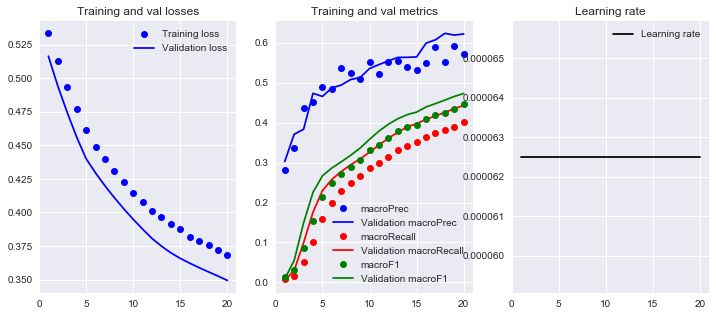

In [28]:
model3a.plot()

---

### Short-Long-Term-Memory

In [ ]:
# embedding: keras layer, trained
# structure: birectional fully connected RNN layer + dense

layers4a = [Bidirectional(LSTM(60, dropout=0.1, recurrent_dropout=0.1)),
            Dense(20, activation='relu')
           ]

model4a = BlackBox(layers=layers4a, loss=my_loss, metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length])
model4a.summary()

In [ ]:
model4.plot()

---
---

# Loss = ...

---

### Dense nets

---

---

---